## Imports

In [1]:
# !pip install rasterio matplotlib folium GDAL

In [ ]:
import os
import glob
import math
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import folium
import xml.etree.ElementTree as ET
import re

from rasterio.coords import BoundingBox
from IPython.display import display
from rasterio.warp import transform_bounds, transform

# Functions

In [3]:
def visualize_iceye_folder(
    folder_path,
    max_per_row=3,
    figsize_per_image=(5, 5),
    use_db_scale=False,           # if True, convert amplitude to dB
    clip_percentiles=(2, 98)      # percentiles for contrast stretch
):
    # 1. Find all GeoTIFFs
    patterns = ['**/*.tif', '**/*.tiff']
    tiff_files = []
    for pat in patterns:
        tiff_files += glob.glob(os.path.join(folder_path, pat), recursive=True)
    tiff_files = sorted(tiff_files)
    if not tiff_files:
        print(f"No GeoTIFFs under {folder_path!r}; contents:", os.listdir(folder_path))
        raise FileNotFoundError(folder_path)
    
    # 2. Print diagnostics for the first file
    with rasterio.open(tiff_files[0]) as src:
        amp = src.read(1).astype(np.float32)
    print("Sample stats for", os.path.basename(tiff_files[0]))
    print("  shape:", amp.shape)
    print("  min/max:", amp.min(), amp.max())
    print("  non-zero count:", np.count_nonzero(amp))
    
    # 3. Prepare plot grid
    n = len(tiff_files)
    cols = min(n, max_per_row)
    rows = math.ceil(n/cols)
    plt.figure(figsize=(figsize_per_image[0]*cols, figsize_per_image[1]*rows))
    
    # 4. Loop through files
    for idx, path in enumerate(tiff_files, start=1):
        with rasterio.open(path) as src:
            amp = src.read(1).astype(np.float32)
        
        # 5. Optional dB conversion
        if use_db_scale:
            # add tiny epsilon to avoid log(0)
            amp = 20 * np.log10(amp + 1e-6)
        
        # 6. Percentile‐clip for contrast
        p_low, p_high = np.percentile(amp.flatten(), clip_percentiles)
        amp_clipped = np.clip(amp, p_low, p_high)
        amp_norm = (amp_clipped - p_low) / (p_high - p_low)
        
        # 7. Plot
        ax = plt.subplot(rows, cols, idx)
        ax.imshow(amp_norm, cmap='gray', vmin=0, vmax=1)
        ax.set_title(os.path.basename(path), fontsize=9)
        ax.axis('off')
    
    plt.savefig('/Users/annalisefishell/Coding/python/MasterThesis/figures/'+folder_path.split('/')[-1]+'.png')
    plt.tight_layout()
    plt.show()

In [4]:
def get_center_from_xml(xml_path):
    """
    Parse ICEYE XML side-car for geolocation.
    Tries:
      1) <*lowerCorner>lon lat</*lowerCorner> + <*upperCorner>lon lat</*upperCorner>
      2) <*posList>lon1 lat1 lon2 lat2 …</*posList>
      3) <*coordinates>…</*coordinates>
    Returns (lat_center, lon_center).
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()

    lower = upper = None
    # First pass: explicit corners
    for elem in root.iter():
        tag = elem.tag.lower()
        if tag.endswith('lowercorner') and elem.text:
            lon, lat = map(float, elem.text.split())
            lower = (lon, lat)
        elif tag.endswith('uppercorner') and elem.text:
            lon, lat = map(float, elem.text.split())
            upper = (lon, lat)
        if lower and upper:
            lon_c = (lower[0] + upper[0]) / 2
            lat_c = (lower[1] + upper[1]) / 2
            return lat_c, lon_c

    # Second pass: posList
    for elem in root.iter():
        tag = elem.tag.lower()
        if tag.endswith('poslist') and elem.text:
            nums = list(map(float, re.split(r'\s+', elem.text.strip())))
            points = list(zip(nums[::2], nums[1::2]))
            lons, lats = zip(*points)
            return sum(lats)/len(lats), sum(lons)/len(lons)

    # Third pass: coordinates
    for elem in root.iter():
        tag = elem.tag.lower()
        if tag.endswith('coordinates') and elem.text:
            nums = list(map(float, re.split(r'[,\s]+', elem.text.strip())))
            points = list(zip(nums[::2], nums[1::2]))
            lons, lats = zip(*points)
            return sum(lats)/len(lats), sum(lons)/len(lons)

    raise RuntimeError(f"No geolocation found in XML {xml_path!r}")

def map_image_location(tif_path, map_zoom=12, output_html="image_location_map.html"):
    # 1. Look for XML side-car
    xml_path = os.path.splitext(tif_path)[0] + '.xml'
    if os.path.isfile(xml_path):
        center_lat, center_lon = get_center_from_xml(xml_path)
    else:
        # 2. Fallback: use rasterio bounds + reprojection (if CRS exists)
        with rasterio.open(tif_path) as src:
            if src.crs:
                bounds = src.bounds
                cx = (bounds.left + bounds.right) / 2
                cy = (bounds.bottom + bounds.top) / 2
                lon, lat = transform(src.crs, 'EPSG:4326', [cx], [cy])
                center_lat, center_lon = lat[0], lon[0]
            else:
                raise RuntimeError(
                    f"No CRS in TIFF and no XML metadata found for {tif_path!r}"
                )

    # 3. Build and save the Folium map
    m = folium.Map(location=[center_lat, center_lon], zoom_start=map_zoom)
    folium.Marker(
        [center_lat, center_lon],
        tooltip="Center of ICEYE scene",
        icon=folium.Icon(color="red", icon="crosshairs")
    ).add_to(m)
    m.save(output_html)


In [ ]:
def vizualize_cappella_data(file_path):
    with rasterio.open(file_path) as src:
        # 2) Read band 1 and convert to dB
        data = src.read(1).astype(np.float32)
        data_db = 10 * np.log10(data + 1e-6)
    
        # 3) Get geographic info
        bounds = src.bounds   # left, bottom, right, top in src.crs
        center = (
            (bounds.left + bounds.right) / 2,
            (bounds.bottom + bounds.top) / 2
        )
        # If you need lon/lat and src.crs isn’t EPSG:4326, transform:
        lon_center, lat_center = rasterio.warp.transform(
            src.crs, "EPSG:4326",
            [center[0]], [center[1]]
        )
    
    # 4) Print location info
    print(f"Bounds (in CRS {src.crs}):")
    print(f"  left={bounds.left:.4f}, bottom={bounds.bottom:.4f}")
    print(f"  right={bounds.right:.4f}, top={bounds.top:.4f}")
    print(f"Center point (lon, lat): {lon_center[0]:.5f}, {lat_center[0]:.5f}")

    # 5) Plot with a simple stretch
    vmin, vmax = np.percentile(data_db, (2, 98))
    plt.figure(figsize=(6,6))
    plt.imshow(data_db, vmin=vmin, vmax=vmax, cmap="gray")
    plt.title("SAR Backscatter (dB)")
    plt.axis("off")
    plt.colorbar(label="dB")
    plt.savefig('/Users/annalisefishell/Coding/python/MasterThesis/figures/'+file_path.split('/')[-1].split('.')[0]+'.png')
    plt.show()

In [ ]:
def find_loc(file_path):
    with rasterio.open(file_path) as src:
        lon_min, lat_min, lon_max, lat_max = transform_bounds(
            src.crs, "EPSG:4326", *src.bounds
        )

        lon_center = (lon_min + lon_max) / 2
        lat_center = (lat_min + lat_max) / 2

    m = folium.Map(location=[lat_center, lon_center], zoom_start=10)

    folium.Marker(
        [lat_center, lon_center],
        popup="Scene Center",
        icon=folium.Icon(color="red", icon="map-marker")
    ).add_to(m)

    footprint = [
        [lat_min, lon_min],
        [lat_max, lon_max]
    ]
    folium.Rectangle(
        bounds=footprint,
        color="blue",
        weight=2,
        fill=False,
        popup="Scene Footprint"
    ).add_to(m)

    m.save('/Users/annalisefishell/Coding/python/MasterThesis/figures/'+file_path.split('/')[-1].split('.')[0]+'.html')

# ICEYE

## ICEYE-Spot-Fine  Strelitz-Alt Germany

Sample stats for ICEYE_X25_GRD_SLEDF_3350334_20240208T233301.tif
  shape: (20000, 20000)
  min/max: 0.00036143875 0.99999994
  non-zero count: 400000000


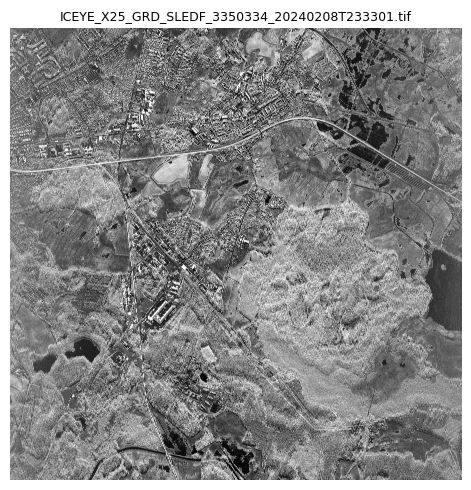

In [5]:
visualize_iceye_folder(
        '/Users/annalisefishell/Coding/python/MasterThesis/data/ICEYE-Spot-Fine-mode',
        use_db_scale=True
    )

In [6]:
tif_file = "/Users/annalisefishell/Coding/python/MasterThesis/data/ICEYE-Spot-Fine-mode/ICEYE_X25_GRD_SLEDF_3350334_20240208T233301.tif"
map_image_location(tif_file, output_html='/Users/annalisefishell/Coding/python/MasterThesis/figures/loc_spot.html')

## ICEYE_Scan_Example_panama_canal

Sample stats for ICEYE_GRD_SC_244270_20220207T192226.tif
  shape: (19120, 20244)
  min/max: 0.0 65534.0
  non-zero count: 386785071


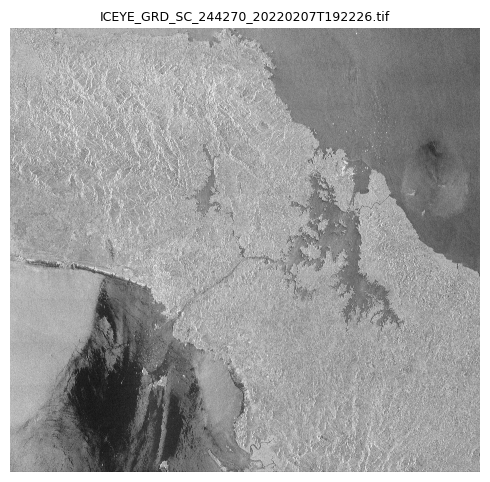

In [8]:
visualize_iceye_folder(
        '/Users/annalisefishell/Coding/python/MasterThesis/data/ICEYE_Scan_Example_Dataset_Panama_Canal_2022',
        use_db_scale=True
    )

## 2631255

Sample stats for ICEYE_X11_GRD_SC_2631255_20230902T005432.tif
  shape: (19510, 19250)
  min/max: 0.0 65535.0
  non-zero count: 375445799


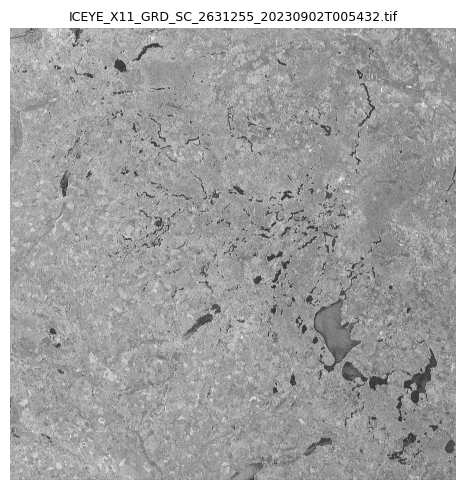

In [9]:
visualize_iceye_folder(
        '/Users/annalisefishell/Coding/python/MasterThesis/data/2631255',
        use_db_scale=True
    )

# Cappella (X-band)

## CAPELLA_C15_SP_GEC_HH_20241028233818_20241028233844

Bounds (in CRS EPSG:32602):
  left=465272.2458, bottom=7413790.8125
  right=474049.8562, top=7422595.9344
Center point (lon, lat): -171.69241, 66.88020


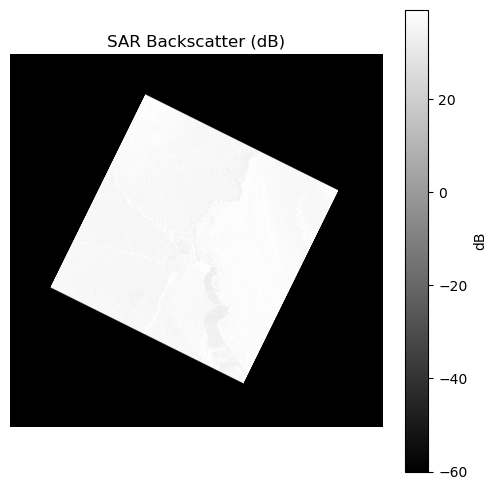

In [ ]:
tif_path = "/Users/annalisefishell/Coding/python/MasterThesis/data/CAPELLA_C15_SP_GEC_HH_20241028233818_20241028233844.tif"
# vizualize_cappella_data(tif_path)
find_loc(tif_path)

In [5]:
find_loc(tif_path)

NameError: name 'transform_bounds' is not defined

## CAPELLA_C15_SP_GEO_HH_20240820012719_20240820012752

In [ ]:
tif_path = "/Users/annalisefishell/Coding/python/MasterThesis/data/CAPELLA_C15_SP_GEO_HH_20240820012719_20240820012752.tif"
# vizualize_cappella_data(tif_path)
find_loc(tif_path)

## CAPELLA_C15_SS_SLC_HH_20240821210822_20240821210837

In [ ]:
tif_path = "/Users/annalisefishell/Coding/python/MasterThesis/data/CAPELLA_C15_SS_SLC_HH_20240821210822_20240821210837.tif"
# vizualize_cappella_data(tif_path)
find_loc(tif_path)